In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import minimize
np.set_printoptions(precision=3, suppress=True)
import matplotlib.patches as mpatches
from itertools import compress

In [2]:
filenames = [
    'PCNA_23-24C_05072022-01.xls',
    'Part2_PCNA_23-24C_26072022-03_Detailed.csv',
    'PCNA_23-24C_12072022-01.csv', 
    'PCNA_23-24C_13072022-02_Detailed.csv', 
    'PCNA_24-25C_12082022-01_AcquisitionBlock1_pt1_Detailed.csv', 
    'PCNA_24-25C_12082022-01_AcquisitionBlock2_pt2_Detailed.csv',
    
    'PCNA_from 1cell_11042023-01_AcquisitionBlock1_pt1_Detailed.csv', 
    'PCNA_06062022-01-2_AcquisitionBlock1_pt1.csv',
    'PCNA_06062022-01-2_AcquisitionBlock2_pt2.csv',
    'PCNA_07062022-01-1_AcquisitionBlock1_pt1.csv',
    'PCNA_07062022-01-1_AcquisitionBlock2_pt2.csv',
    'PCNA_07062022-01-1_AcquisitionBlock3_pt3.csv',
    
    'wee1 inhibitor in PCNA_2602023-01_AcquisitionBlock1_pt1_Detailed.csv',
    'wee1 inhibitor in PCNA_2602023-01_AcquisitionBlock2_pt2_Detailed.csv',
    'chek1_12pg_11082023-01-2_AcquisitionBlock1_Detailed.csv',
    'chek1_12pg_11082023-01-2_AcquisitionBlock2_Detailed.csv',
    'Continuous Wee1 inh_50uM_14082023-01_AcquisitionBlock1_Detailed.csv',
    'Continuous Wee1 inh_50uM_14082023-01_AcquisitionBlock2_Detailed.csv', 
    
    '0_35pc DMSO_PCNA_28072023-01-1_AcquisitionBlock1_Detailed.csv', 
    '0_35pc DMSO_PCNA_28072023-01-1_AcquisitionBlock2_Detailed.csv', 
    
    'AurB_chek1_12pg_25082023-01_AcquisitionBlock1.csv', # AurB + chek 1 
    'AurB_chek1_12pg_25082023-01_AcquisitionBlock2.csv', 
    'AurB_chek1_12pg_25082023-01_AcquisitionBlock3.csv',
    'AurB_Chek1_12pg_23082023-01_AcquisitionBlock2.csv', 
    'AurB inh in PCNA_21072023-01_AcquisitionBlock2.csv', # AurB only   
    
    'LatB_02102023-01_AcquisitionBlock1.csv', # LatB 
    'LatB_02102023-01_AcquisitionBlock2.csv', 
    'LatB_04102023-01-3_AcquisitionBlock1.csv', 
    'LatB_04102023-01-3_AcquisitionBlock2_Detailed.csv',
]

labels = ['WT', 'wee1', 'chek1', 'DMSO', 'AurB+chek1', 'AurB', 'LatB']
pert_type = np.array([*([0]*12), 1, 1, 2, 2, 1, 1, 3, 3, 4, 4, 4, 4, 5, 6, 6, 6, 6]) # 0 for WT, 1 for wee, 2 for chek1, 3 for DMSO 

fits = [np.load('Data/' + f[:-4] + '_fits.npy') for f in filenames]


excludes = np.array([
            [1, 0], [0, -3],[1, 0],[1, -2],[2, -2],[2, -2],
            [3, -1],[4, -1],[3, -1],[1, -1], [4, -1],[3, -1],
            [1, -3], [1, -3], [0, -1], [0, -2],[0, 0], [0, -3], 
            [3, -3], [1, -4], 
            [1, -4], [3, -4], [0, -4], [1, -4], [1, -1], 
            [1, -1], [1, -1], [2, -1], [3, -1]], dtype ='int')

start_frames = [
    [ 55, 158, 255, 350, 444, 536, 628], # PCNA
    [52, 145, 238, 334, 405, 514, 641], 
    [42, 143, 241, 336, 430, 524], 
    [ 53, 147, 238, 327, 419, 514, 616, 671],
    [ 26,  72, 118, 162, 206, 251, 287, 337],
    [ 26,  73, 118, 162, 206, 251, 289, 329],
    
    [ 26,  74, 120, 164, 207, 250, 293, 333], # PCNA 
    [  8,  44,  80, 113, 145, 176, 209, 240],
    [  3,  38,  72, 103, 134, 166, 198, 231], 
    [ 41,  73, 104, 135, 167, 199, 217],
    [ 39,  69,  99, 129, 160, 191, 226],
    [39,  71, 103, 134, 166, 199, 234],
    
    [  9,  43,  78, 114, 148, 184, 215, 258, 304], # wee1 
    [  9,  43,  78, 114, 148, 184, 223, 258, 304], # wee1 
    [ 10,  53,  95, 136, 178, 223], # chek1
    [  7,  50,  92, 133, 174, 215, 257], # check1 
    [ 17,  51,  87, 121, 164], # cont_wee1 
    [ 18,  54,  91, 128, 168, 212, 252, 299], # cont_wee1 
    
    [ 15,  52,  89, 126, 161, 197, 234, 270, 306, 357], # DMSO 
    [ 20,  56,  93, 129, 164, 200, 237, 274, 311, 359],
    
    [3, 32,  62,  92, 123, 156, 191, 224, 260, 314],
    [8, 38,  69, 100,   130, 162, 195, 235, 319, 425],
    [ 17,  48,  78, 109, 141, 174, 205, 239, 286],
    [ 25,  70, 115, 160, 207, 255, 345, 422],
    [ 18,  57,  96, 136, 175, 216, 259, 336],
    
    [7,  49,  92, 134, 176, 219, 262, 309, 367], # LatB
    [6,  47,  89, 132, 174, 218, 264, 310], 
    [7,  50,  94, 136, 179, 222, 264, 305],
    [5,  47,  91, 135, 177, 220, 265, 310]
]

frame_to_times = np.array([
    18.86, 18.88, 18.87, 18.87, 37.16, 37.16, 
    38.97, 52, 52, 52, 52, 52, 
    39.86, 39.86, 39.86, 39.86, 39.86, 39.86, 
    39.86, 39.86, 
    57.4, 57.4, 57.4, 38.6, 38.07, 
    41.5, 41.5, 41.5, 41.5
])        

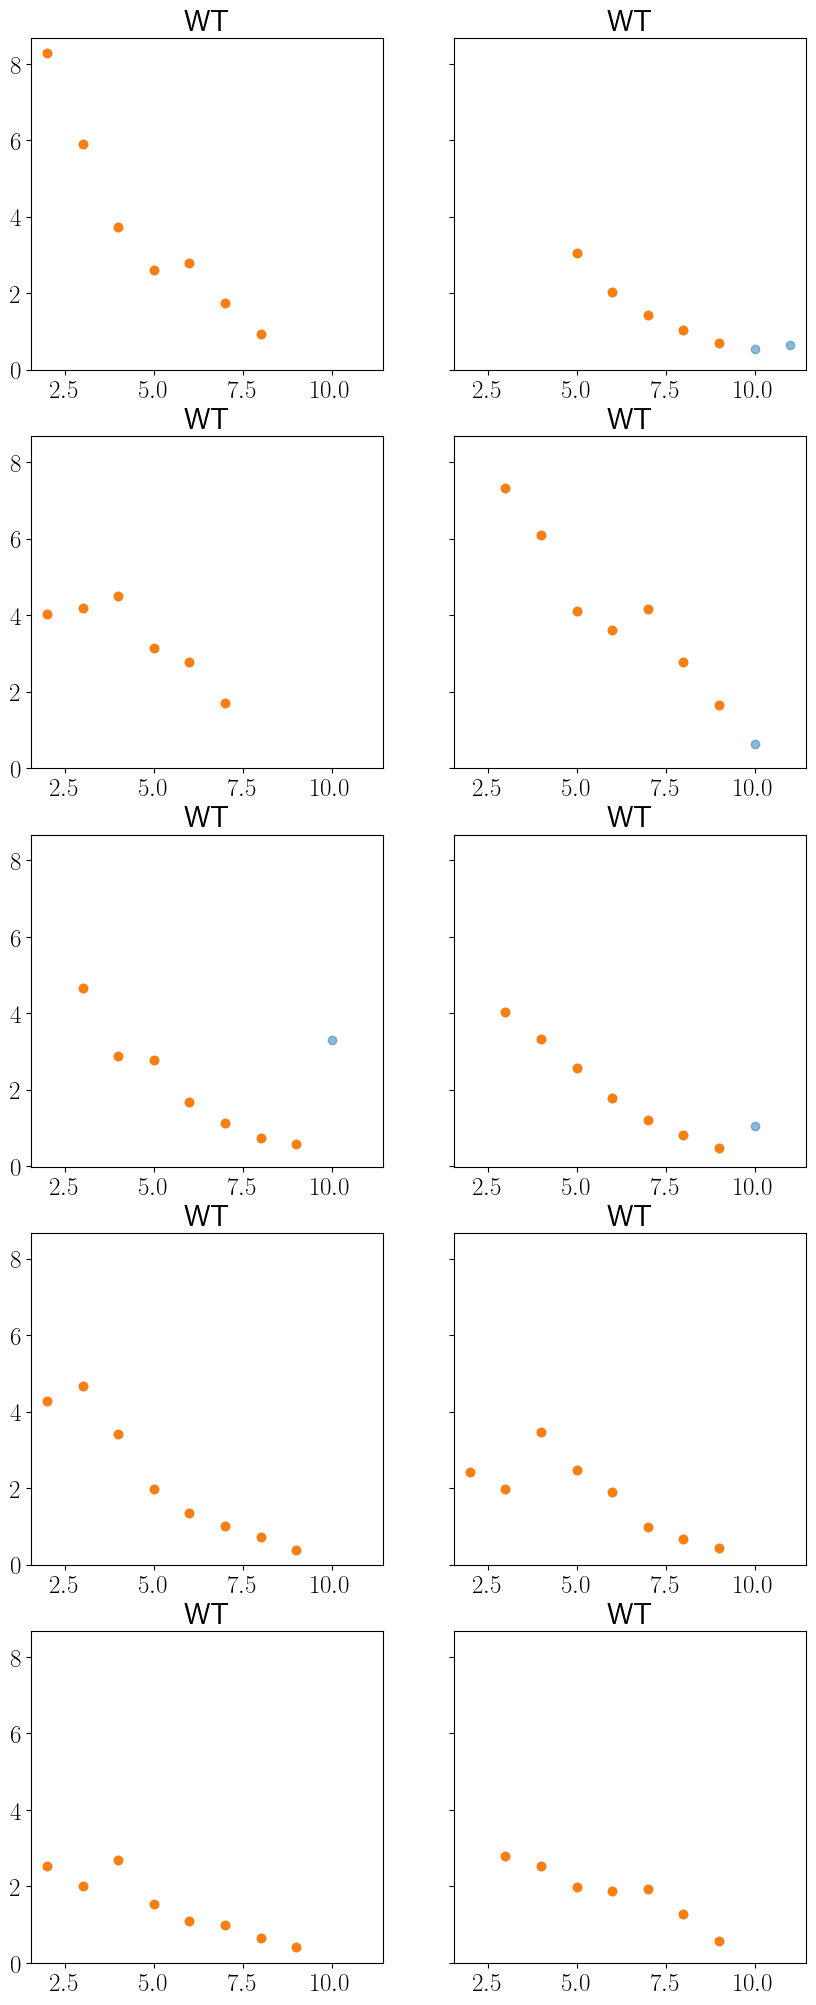

In [148]:
fig, axes = plt.subplots(5, 2, sharey=True, sharex=True, figsize=(10, 25))

for (index, n) in enumerate(range(12)):
    a, b = excludes[n]
    F = fits[n]
    m = F[:, 4]
    round_n = F[:, 5]
    
    a = 0 # int(max(0, 4-round_n[0]))
    b = int(min(len(round_n), 9-round_n[-1]+len(round_n)))
    
    excludes[n] = (a, b)
    if index < 10: 
        i, j = np.unravel_index(index, (5, 2))
        
        axes[i, j].plot(round_n, m, 'o', alpha=0.5)
        axes[i, j].plot(round_n[a:b], m[a:b], 'o', alpha=1)
        axes[i, j].xaxis.set_tick_params(labelbottom=True)
        axes[i, j].set_title(labels[pert_type[n]])
#     a = int(max(a, 4-round_n[0]))
#     b = int(min(b+len(round_n), 9-round_n[-1] + len(round_n)))

plt.show() 

In [149]:
datasets_all = [] 
datasets_select = [] 
durations = [] 
params = [] 

for i in range(1): 
    m = (pert_type == i)
    pert_fits = list(compress(fits, m))

    d = np.concatenate([f[a:b, 4:] for (f, (a, b)) in zip(pert_fits, excludes[m])])
    datasets_select.append(d)
    
    n = d[:, 1] 
    v = d[:, 0]*60
    
    print(n)
    params.append(np.sum(v/n)/np.sum(1/n/n)) # square residual fit 

    d = np.concatenate([f[:, 4:] for f in pert_fits])
    datasets_all.append(d)
    
#     n = d[:, 1] 
#     v = d[:, 0]*60 
    
#     print(n)
#     params.append(np.sum(v/n)/np.sum(1/n/n)) # square residual fit 

[2. 3. 4. 5. 6. 7. 8. 5. 6. 7. 8. 9. 2. 3. 4. 5. 6. 7. 3. 4. 5. 6. 7. 8.
 9. 3. 4. 5. 6. 7. 8. 9. 3. 4. 5. 6. 7. 8. 9. 2. 3. 4. 5. 6. 7. 8. 9. 2.
 3. 4. 5. 6. 7. 8. 9. 2. 3. 4. 5. 6. 7. 8. 9. 3. 4. 5. 6. 7. 8. 9. 3. 4.
 5. 6. 7. 8. 9. 3. 4. 5. 6. 7. 8. 9.]


In [150]:
print(params)

[663.5572248641885]


In [151]:
def bin_data(x, y): 

    # Step 1: Bin the data
    bins = np.arange(min(x)-0.5, max(x)+1.5, 1)  # Create 10 bins between 0 and 10
    bin_indices = np.digitize(x, bins)  # Get bin indices for each x-value

    # Step 2: Calculate mean and standard deviation for each bin
    bin_means = [y[bin_indices == i].mean() for i in range(1, len(bins))]
    bin_stds = [y[bin_indices == i].std() for i in range(1, len(bins))]

    # Step 3: Plot the bar plot with error bars
    plt.bar(bins[:-1], bin_means, width=np.diff(bins), align='edge', yerr=bin_stds, capsize=5, alpha=0.5, color='darkorange')

In [153]:
np.savetxt('Data/velocities.csv', datasets_select[0], delimiter=',', fmt='%.5f')

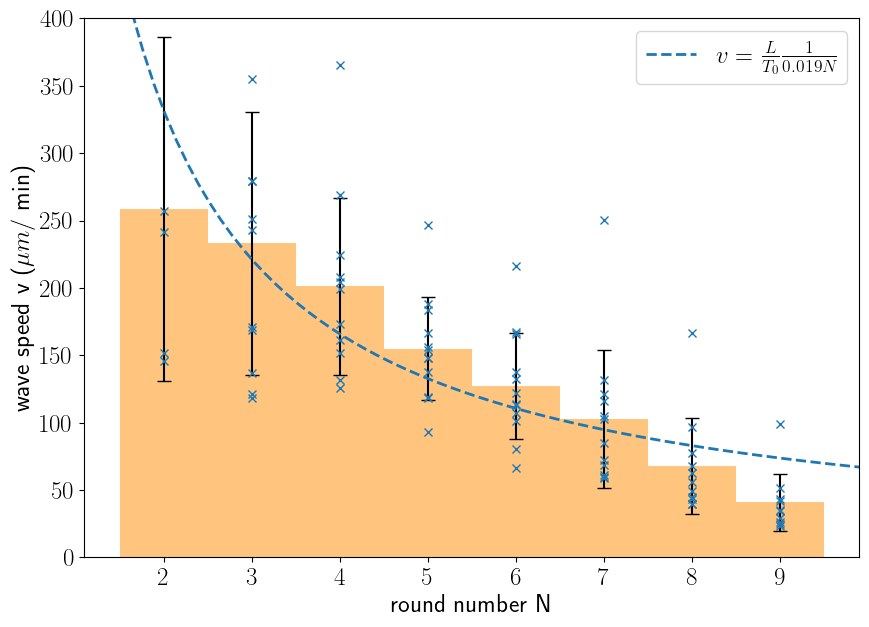

In [157]:
colors = plt.cm.tab10.colors

plt.rc('font', size=18)
plt.rcParams['text.usetex'] = True

plt.figure(figsize=(10, 7))

round_n = np.linspace(0.5, 13, 100)
for n in [0]:
    d = datasets_select[n]
    bin_data(d[:, 1], d[:, 0]*60)
    plt.plot(d[:, 1], d[:, 0]*60, 'x', alpha=1, color=colors[n])

#     d = datasets_all[n]
#     bin_data(d[:, 1], d[:, 0]*60)
#     plt.plot(d[:, 1], d[:, 0]*60, 'x', color=colors[n])
    
    m = params[n] 
    k = 1/(m/(350/(1700/60)))
    plt.plot(round_n, params[n]/round_n, color=colors[n], linewidth='2', linestyle='--', label=r'$v = \frac{{L}}{{T_0}} \frac{{1}}{{  {:.3f} N}}$'.format(k))
    
plt.legend() 
plt.xlim([1.1, 9.9])
plt.ylim([0, 400])
plt.xlabel('round number N')
plt.ylabel(r'wave speed v ($\mu m /$ min)')
# plt.savefig('Figures/waves_speed.png')
plt.show() 

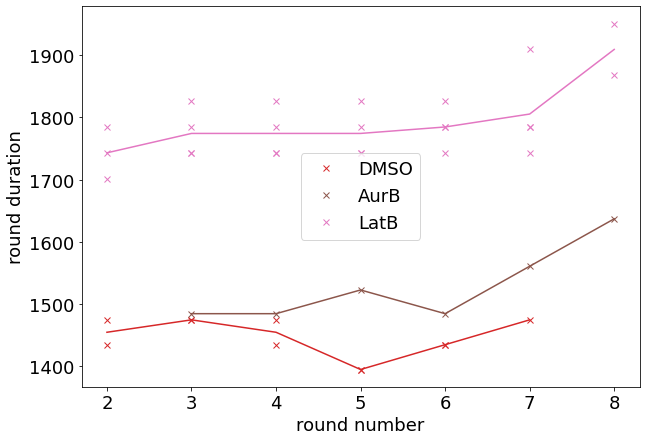

In [6]:
# plot period vs rounds for three types 
total_rounds = np.arange(2, 9, 1)

plt.rc('font', size=18)
plt.figure(figsize=(10, 7))
for i in [3, 5, 6]: 
    m = (pert_type == i)
    pert_fits = compress(fits, m)
    pert_starts = compress(start_frames, m)
    
    durations = []
    rounds = [] 
    
    for (f, s, f2t, (_, b)) in zip(pert_fits, pert_starts, frame_to_times[m], excludes[m]):
        b = min(b-1, -1)
        s = np.array(s)
        d = ((s[1:]-s[:-1])*f2t)[0:b+len(s)]
        durations.extend(d) 
        rounds.extend(f[:, 5][0:b+len(s)])
        
    plt.plot(rounds, durations, 'x', color=colors[i], label=labels[i])
    
    m_durations = [] 
    for r in total_rounds: 
        temp = np.array(durations)[np.array(rounds) == r]
        if temp.size == 0: 
            m_durations.append(0) 
        else: 
            m_durations.append(np.mean(temp))
    m_durations = np.array(m_durations)
    m = m_durations > 0 
    plt.plot(total_rounds[m], m_durations[m], color=colors[i])

plt.legend()
plt.xlabel('round number')
plt.ylabel('round duration')
plt.savefig('Figures/round_duration.png')
plt.show() 